# Text cleaning

In [2]:
import re

def find_urls(text):
	"""Find all mentioned urls in a piece of text"""

	url_list = []
	myString_list = [item for item in text.split(" ")]

	# Re search for urls
	for item in myString_list:
		try:
			var = re.search("(?P<url>https?://[^\s]+)", item).group("url")
			url_list.append(var)
		except:
			var = ''
			url_list.append(var)

	# Filter out blanks
	url_list = list(filter(None, url_list))

	return url_list


def clean_text(text):
	text = str(text)
	### Remove URLs
	urls = find_urls(text)
	for url in urls:
		text = text.replace(url, '')

	### Remove Hashtags
	hashtags = [i for i in text.split() if i.startswith("#")]
	for hashtag in hashtags:
		text = text.replace(hashtag, '')

	### Remove @ signs
	text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

	cleantext = re.sub(re.compile('<.*?>'), '', text)
	cleantext = ''.join([i if ord(i) < 128 else ' ' for i in cleantext])
	removers = ['<p>', '</p>', '<em>', '</em>', '<a>', '<span>', '</span>',
				'</a>', '/n', '\n', '\t', '[', ']', "\'\\n", '=', '\n', ':', '*', '/',
				'|', '@', '#', '...', '"', "'", '. .', '. . .', '..', '. . . . .',
				'..', '.....', '........', '. . ', '?', '!', ';', ':']

	for remove in removers:
		cleantext = cleantext.replace(remove, '')

	cleantext = re.sub(r'<[^=>]*?>', '', cleantext)
	cleantext = re.sub('\s+', ' ', cleantext).strip()
	cleantext = re.sub(r'([^\s\w]|_)+', '', cleantext)

	return cleantext

# Get features

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import tensorflow_hub as hub
import pandas as pd

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def text_features(corpus):
    """ Convert documents to text vector """

    with tf.compat.v1.Session() as session:
        session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
        message_embeddings = session.run(embed(corpus))
    
    return pd.DataFrame(message_embeddings)

# Labelling

In [4]:
from pke.unsupervised import TopicRank

def automatic_labelling(df, col='corpus', label_col='labels'):
	mapping = {}

	for label in df[label_col].unique():
			extractor = TopicRank()
			tx = ' '.join(df[df[label_col] == label][col].tolist())

			extractor.load_document(input=tx,language="en",normalization=None)

			# select the keyphrase candidates, for TopicRank the longest sequences of
			# nouns and adjectives
			extractor.candidate_selection(pos={'NOUN', 'PROPN', 'ADJ'})

			# weight the candidates using a random walk. The threshold parameter sets the
			# minimum similarity for clustering, and the method parameter defines the
			# linkage method
			extractor.candidate_weighting(threshold=0.5,
										  method='average')

			# print the n-highest (10) scored candidates
			cluster_labels = ' | '.join(
				[keyphrase for keyphrase, score in extractor.get_n_best(n=10, stemming=True)][0:5])
			mapping[label] = cluster_labels
			print('-' * 30)
			print(cluster_labels)

	df['cluster_name'] = df[label_col].map(mapping)

	return df


# Reduction

In [5]:
import umap
import hdbscan

def Mapper(X, corpus,min_dist = 0.0, n_components = 2, n_neighbors=5):

	u = umap.UMAP(
		n_neighbors=n_neighbors,
		min_dist=min_dist,
		n_components=n_components,
		random_state=42,
	).fit_transform(X)

	labels = hdbscan.HDBSCAN(
		min_samples=4,
		min_cluster_size=4,
	).fit_predict(u)

	X_coords, y_coords = u[:, 0], u[:, 1]
	data = {'X':X_coords,'Y':y_coords,'labels':labels,'corpus':corpus}

	return pd.DataFrame(data)

# Get text list 

In [6]:
import numpy as np
import os
from random import shuffle
import re
import pandas as pd 
import spacy
nlp = spacy.load("en_core_web_sm")

In [7]:
def proprocess_text(string_list):
    final_str_list = []
    for s in string_list:
        doc = nlp(s)
        new_list =[]
        for token in doc:
            if token.pos_ == 'ADJ' or token.pos_ == 'ADV' or token.pos_ == 'NOUN' or token.pos_ == 'PROPN' or token.pos_ == 'VERB':
                new_list.append(token.text)
        final_str_list.append(" ".join(new_list))
    return final_str_list

In [8]:
my_df = pd.read_csv("/Users/sdeshpande/Desktop/bioinformatices/full_articlesLDA.csv")
my_df.dropna(subset = ['title'], inplace = True)
my_df = my_df[:10000]
titles = my_df.title.tolist()
titles_processed = proprocess_text(titles)

In [9]:
titles_processed = titles_processed[0:50]

In [10]:
tf = text_features(titles_processed)

In [11]:
tf.shape

(50, 512)

In [12]:
data = Mapper(tf.values, titles_processed)
mapping = automatic_labelling(data)

------------------------------
o-1 acute | antigens infected cells | infectious peritonitis virus | hemorrhagic diarrhea syndrome dogs | oral pimobendan
------------------------------
south africa adaptive dispersal effect | animals domestic livestock farms | disease patchy environment | surveillance hospital
------------------------------
isothermal amplification | cat-1 expression loop | diagnosis retinitis | h5 subtype avian influenza
------------------------------
marine natural products | source cancer drug | untranslated region norwalk virus | immunity pathogens
------------------------------
thermal | flow | effective way | single chain | nucleolar cytoplasmic


In [13]:
mapping.head()

,X,Y,labels,corpus,cluster_name
0,8.190208,3.860288,2,Absence surface expression feline infectious p...,o-1 acute | antigens infected cells | infectio...
1,4.434482,2.929166,1,Correlation antimicrobial consumption incidenc...,south africa adaptive dispersal effect | anima...
2,4.867089,2.228050,1,Laboratory based surveillance hospital acquire...,south africa adaptive dispersal effect | anima...
3,4.843434,1.587922,-1,Pneumonie virale sévère l'immunocompétent Vira...,isothermal amplification | cat-1 expression lo...
4,7.283730,3.423765,-1,Microheterogeneity S glycoprotein mouse hepati...,isothermal amplification | cat-1 expression lo...


In [14]:
mapping['labels'].nunique()
mapping['labels'].unique()

array([ 2,  1, -1,  3,  0])

<AxesSubplot:xlabel='X', ylabel='Y'>

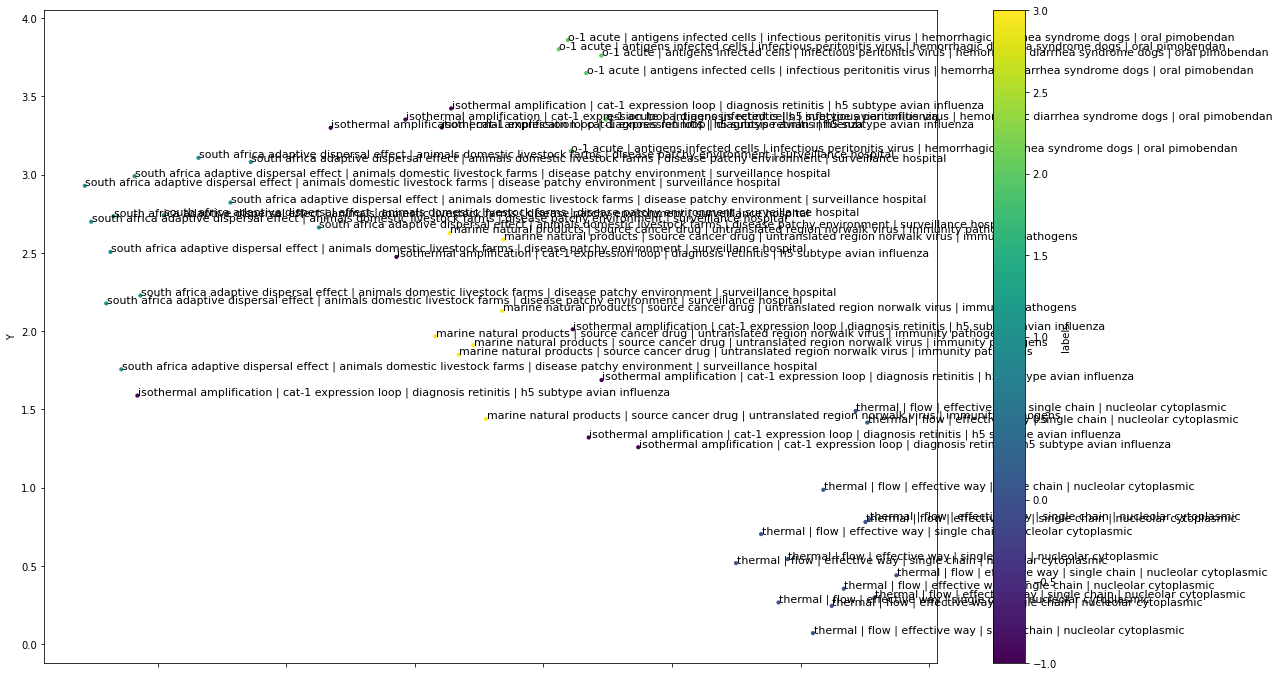

In [15]:
ax = mapping.plot.scatter("X", "Y", s=10, figsize=(20, 12), c = "labels", cmap='viridis')
for i, point in mapping.iterrows():
        ax.text(point.X + 0.005, point.Y + 0.005, point.cluster_name, fontsize=11)
ax

# Topic Modelling libraries 

# 1. Utility libraries

In [16]:
# -*- coding: utf-8 -*-

"""Data structures for the pke module."""


class Sentence(object):
    """The sentence data structure."""

    def __init__(self, words):

        self.words = words
        """list of words (tokens) in the sentence."""

        self.pos = []
        """list of Part-Of-Speeches."""

        self.stems = []
        """list of stems."""

        self.length = len(words)
        """length (number of tokens) of the sentence."""

        self.meta = {}
        """meta-information of the sentence."""

    def __eq__(self, other):
        """Compares two sentences for equality."""

        # test whether they are instances of different classes
        if type(self) != type(other):
            return False

        # test whether they are of same length
        if self.length != other.length:
            return False

        # test whether they have the same words
        if self.words != other.words:
            return False

        # test whether they have the same PoS tags
        if self.pos != other.pos:
            return False

        # test whether they have the same stem forms
        if self.stems != other.stems:
            return False

        # test whether they have the same meta-information
        if self.meta != other.meta:
            return False

        # if everything is ok then they are equal
        return True


class Candidate(object):
    """The keyphrase candidate data structure."""

    def __init__(self):

        self.surface_forms = []
        """ the surface forms of the candidate. """

        self.offsets = []
        """ the offsets of the surface forms. """

        self.sentence_ids = []
        """ the sentence id of each surface form. """

        self.pos_patterns = []
        """ the Part-Of-Speech patterns of the candidate. """

        self.lexical_form = []
        """ the lexical form of the candidate. """


class Document(object):
    """The Document data structure."""

    def __init__(self):

        self.input_file = None
        """ The path of the input file. """

        self.sentences = []
        """ The sentence container (list of Sentence). """

    @staticmethod
    def from_sentences(sentences, **kwargs):
        """Populate the sentence list.
        Args:
            sentences (Sentence list): content to create the document.
            input_file (str): path to the input file.
        """

        # initialize document
        doc = Document()

        # set the input file
        doc.input_file = kwargs.get('input_file', None)

        # loop through the parsed sentences
        for i, sentence in enumerate(sentences):

            # add the sentence to the container
            s = Sentence(words=sentence['words'])

            # add the POS
            s.pos = sentence['POS']

            # add the lemmas
            s.stems = sentence['lemmas']

            # add the meta-information
            for (k, infos) in sentence.items():
                if k not in {'POS', 'lemmas', 'words'}:
                    s.meta[k] = infos

            # add the sentence to the document
            doc.sentences.append(s)

        return doc

    def __eq__(self, other):
        """Compares two documents for equality."""

        # test whether they are instances of different classes
        if type(self) != type(other):
            return False

        # test whether they have the same language
        if self.language != other.language:
            return False

        # test whether they have the same input path
        if self.input_file != other.input_file:
            return False

        # test whether they contain the same lists of sentences
        if self.sentences != other.sentences:
            return False

        # if everything is ok then they are equal
        return True


In [17]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""Readers for the pke module."""

import xml.etree.ElementTree as etree
import spacy

class Reader(object):
    def read(self, path):
        raise NotImplementedError


class MinimalCoreNLPReader(Reader):
    """Minimal CoreNLP XML Parser."""

    def __init__(self):
        self.parser = etree.XMLParser()

    def read(self, path, **kwargs):
        sentences = []
        tree = etree.parse(path, self.parser)
        for sentence in tree.iterfind('./document/sentences/sentence'):
            # get the character offsets
            starts = [int(u.text) for u in
                      sentence.iterfind("tokens/token/CharacterOffsetBegin")]
            ends = [int(u.text) for u in
                    sentence.iterfind("tokens/token/CharacterOffsetEnd")]
            sentences.append({
                "words": [u.text for u in
                          sentence.iterfind("tokens/token/word")],
                "lemmas": [u.text for u in
                           sentence.iterfind("tokens/token/lemma")],
                "POS": [u.text for u in sentence.iterfind("tokens/token/POS")],
                "char_offsets": [(starts[k], ends[k]) for k in
                                 range(len(starts))]
            })
            sentences[-1].update(sentence.attrib)

        doc = Document.from_sentences(sentences, input_file=path, **kwargs)

        return doc


class RawTextReader(Reader):
    """Reader for raw text."""

    def __init__(self, language=None):
        """Constructor for RawTextReader.
        Args:
            language (str): language of text to process.
        """

        self.language = language

        if language is None:
            self.language = 'en'

    def read(self, text, **kwargs):
        """Read the input file and use spacy to pre-process.
        Args:
            text (str): raw text to pre-process.
            max_length (int): maximum number of characters in a single text for
                spacy, default to 1,000,000 characters (1mb).
        """

        max_length = kwargs.get('max_length', 10**6)
        nlp = spacy.load(self.language,
                         max_length=max_length)
        spacy_doc = nlp(text)

        sentences = []
        for sentence_id, sentence in enumerate(spacy_doc.sents):
            sentences.append({
                "words": [token.text for token in sentence],
                "lemmas": [token.lemma_ for token in sentence],
                "POS": [token.pos_ for token in sentence],
                "char_offsets": [(token.idx, token.idx + len(token.text))
                                     for token in sentence]
            })

        doc = Document.from_sentences(sentences,
                                      input_file=kwargs.get('input_file', None),
                                      **kwargs)

        return doc


In [18]:
# -*- coding: utf-8 -*-

"""Useful functions for the pke module."""

from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import os
import csv
import math
import glob
import pickle
import gzip
import json
import codecs
import logging

from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords


def load_document_frequency_file(input_file,
                                 delimiter='\t'):
    """Load a tsv (tab-separated-values) file containing document frequencies.
    Automatically detects if input file is compressed (gzip) by looking at its
    extension (.gz).
    Args:
        input_file (str): the input file containing document frequencies in
            csv format.
        delimiter (str): the delimiter used for separating term-document
            frequencies tuples, defaults to '\t'.
    Returns:
        dict: a dictionary of the form {term_1: freq}, freq being an integer.
    """

    # initialize the DF dictionary
    frequencies = {}

    # open the input file
    with gzip.open(input_file, 'rt') if input_file.endswith('.gz') else \
            codecs.open(input_file, 'rt') as f:
        # read the csv file
        df_reader = csv.reader(f, delimiter=delimiter)

        # populate the dictionary
        for row in df_reader:
            frequencies[row[0]] = int(row[1])

    # return the populated dictionary
    return frequencies


def compute_document_frequency(input_dir,
                               output_file,
                               extension='xml',
                               language='en',
                               normalization="stemming",
                               stoplist=None,
                               delimiter='\t',
                               n=3):
    """Compute the n-gram document frequencies from a set of input documents. An
    extra row is added to the output file for specifying the number of
    documents from which the document frequencies were computed
    (--NB_DOC-- tab XXX). The output file is compressed using gzip.
    Args:
        input_dir (str): the input directory.
        output_file (str): the output file.
        extension (str): file extension for input documents, defaults to xml.
        language (str): language of the input documents (used for computing the
            n-stem or n-lemma forms), defaults to 'en' (english).
        normalization (str): word normalization method, defaults to 'stemming'.
            Other possible values are 'lemmatization' or 'None' for using word
            surface forms instead of stems/lemmas.
        stoplist (list): the stop words for filtering n-grams, default to None.
        delimiter (str): the delimiter between n-grams and document frequencies,
            defaults to tabulation (\t).
        n (int): the size of the n-grams, defaults to 3.
    """

    # document frequency container
    frequencies = defaultdict(set)

    # initialize number of documents
    nb_documents = 0

    # loop through the documents
    for input_file in glob.glob(input_dir + '/*.' + extension):

        logging.info('reading file ' + input_file)

        # initialize load file object
        doc = LoadFile()

        # read the input file
        doc.load_document(input=input_file,
                          language=language,
                          normalization=normalization)

        # candidate selection
        doc.ngram_selection(n=n)

        # filter candidates containing punctuation marks
        doc.candidate_filtering(stoplist=stoplist)

        # loop through candidates
        for lexical_form in doc.candidates:
            frequencies[lexical_form].add(input_file)

        nb_documents += 1

    # create directories from path if not exists
    if os.path.dirname(output_file):
        os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # dump the df container
    with gzip.open(output_file, 'wb') as f:

        # add the number of documents as special token
        first_line = '--NB_DOC--' + delimiter + str(nb_documents)
        f.write(first_line.encode('utf-8') + b'\n')

        for ngram in frequencies:
            line = ngram + delimiter + str(len(frequencies[ngram]))
            f.write(line.encode('utf-8') + b'\n')


def train_supervised_model(input_dir,
                           reference_file,
                           model_file,
                           extension='xml',
                           language='en',
                           normalization="stemming",
                           df=None,
                           model=None,
                           sep_doc_id=':',
                           sep_ref_keyphrases=',',
                           normalize_reference=False):
    """Build a supervised keyphrase extraction model from a set of documents and
    a reference file.
    Args:
        input_dir (str): the input directory.
        reference_file (str): the reference file.
        model_file (str): the model output file.
        extension (str): file extension for input documents, defaults to xml.
        language (str): language of the input documents (used for computing the
            n-stem or n-lemma forms), defaults to 'en' (english).
        normalization (str): word normalization method, defaults to 'stemming'.
            Other possible values are 'lemmatization' or 'None' for using word
            surface forms instead of stems/lemmas.
        df (dict): df weights dictionary.
        model (object): the supervised model to train, defaults to Kea.
        sep_doc_id (str): the separator used for doc_id in reference file,
            defaults to ':'.
        sep_ref_keyphrases (str): the separator used for keyphrases in
            reference file, defaults to ','.
        normalize_reference (bool): whether to normalize the reference
            keyphrases, default to False.
    """

    logging.info('building model {} from {}'.format(model, input_dir))

    references = load_references(reference_file,
                                 sep_doc_id=sep_doc_id,
                                 sep_ref_keyphrases=sep_ref_keyphrases,
                                 normalize_reference=normalize_reference,
                                 language=language)
    training_instances = []
    training_classes = []

    # get the input files from the input directory
    for input_file in glob.glob(input_dir + '/*.' + extension):

        logging.info('reading file {}'.format(input_file))

        # initialize the input file
        model.__init__()

        # get the document id from file name
        doc_id = '.'.join(input_file.split('/')[-1].split('.')[0:-1])

        # load the document
        model.load_document(input=input_file,
                            language=language,
                            normalization=normalization)

        # candidate selection
        model.candidate_selection()

        # extract features
        model.feature_extraction(df=df, training=True)

        # annotate the reference keyphrases in the instances
        for candidate in model.instances:
            if candidate in references[doc_id]:
                training_classes.append(1)
            else:
                training_classes.append(0)
            training_instances.append(model.instances[candidate])

    logging.info('writing model to {}'.format(model_file))
    model.train(training_instances=training_instances,
                training_classes=training_classes,
                model_file=model_file)


def load_references(input_file,
                    sep_doc_id=':',
                    sep_ref_keyphrases=',',
                    normalize_reference=False,
                    language="en",
                    encoding='utf-8'):
    """Load a reference file. Reference file can be either in json format or in
    the SemEval-2010 official format.
    Args:
        input_file (str): path to the reference file.
        sep_doc_id (str): the separator used for doc_id in reference file,
            defaults to ':'.
        sep_ref_keyphrases (str): the separator used for keyphrases in
            reference file, defaults to ','.
        normalize_reference (bool): whether to normalize the reference
            keyphrases using stemming, default to False.
        language (str): language of the input documents (used for computing the
            stems), defaults to 'en' (english).
        encoding (str): file encoding, default to utf-8.
    """

    logging.info('loading reference keyphrases from {}'.format(input_file))

    references = defaultdict(list)

    # open input file
    with codecs.open(input_file, 'r', encoding) as f:

        # load json data
        if input_file.endswith('.json'):
            references = json.load(f)
            for doc_id in references:
                references[doc_id] = [keyphrase for variants in
                                      references[doc_id] for keyphrase in
                                      variants]
        # or load SemEval-2010 file
        else:
            for line in f:
                cols = line.strip().split(sep_doc_id)
                doc_id = cols[0].strip()
                keyphrases = cols[1].strip().split(sep_ref_keyphrases)
                for v in keyphrases:
                    if '+' in v:
                        for s in v.split('+'):
                            references[doc_id].append(s)
                    else:
                        references[doc_id].append(v)

        # normalize reference if needed
        if normalize_reference:

            # initialize stemmer
            stemmer = SnowballStemmer("porter")
            if language != 'en':
                stemmer = SnowballStemmer(ISO_to_language[language],
                                          ignore_stopwords=True)

            for doc_id in references:
                for i, keyphrase in enumerate(references[doc_id]):
                    stems = [stemmer.stem(w) for w in keyphrase.split()]
                    references[doc_id][i] = ' '.join(stems)

    return references


def compute_lda_model(input_dir,
                      output_file,
                      n_topics=500,
                      extension="xml",
                      language="en",
                      normalization="stemming"):
    """Compute a LDA model from a collection of documents. Latent Dirichlet
    Allocation is computed using sklearn module.
    Args:
        input_dir (str): the input directory.
        output_file (str): the output file.
        n_topics (int): number of topics for the LDA model, defaults to 500.
        extension (str): file extension for input documents, defaults to xml.
        language (str): language of the input documents, used for stop_words
            in sklearn CountVectorizer, defaults to 'en'.
        normalization (str): word normalization method, defaults to 'stemming'.
            Other possible values are 'lemmatization' or 'None' for using word
            surface forms instead of stems/lemmas.
    """

    # texts container
    texts = []

    # loop throught the documents
    for input_file in glob.glob(input_dir + '/*.' + extension):

        logging.info('reading file {}'.format(input_file))

        # initialize load file object
        doc = LoadFile()

        # read the input file
        doc.load_document(input=input_file,
                          language=language,
                          normalization=normalization)

        # container for current document
        text = []

        # loop through sentences
        for sentence in doc.sentences:
            # get the tokens (stems) from the sentence if they are not
            # punctuation marks 
            text.extend([sentence.stems[i] for i in range(sentence.length)
                         if sentence.pos[i] != 'PUNCT' and
                         sentence.pos[i].isalpha()])

        # add the document to the texts container
        texts.append(' '.join(text))

    # vectorize dataset
    # get the stoplist from nltk because CountVectorizer only contains english
    # stopwords atm
    tf_vectorizer = CountVectorizer(
        stop_words=stopwords.words(ISO_to_language[language]))
    tf = tf_vectorizer.fit_transform(texts)

    # extract vocabulary
    vocabulary = tf_vectorizer.get_feature_names()

    # create LDA model and train
    lda_model = LatentDirichletAllocation(n_components=n_topics,
                                          random_state=0,
                                          learning_method='batch')
    lda_model.fit(tf)

    # save all data necessary for later prediction
    saved_model = (vocabulary,
                   lda_model.components_,
                   lda_model.exp_dirichlet_component_,
                   lda_model.doc_topic_prior_)

    # Dump the df container
    logging.info('writing LDA model to {}'.format(output_file))

    # create directories from path if not exists
    if os.path.dirname(output_file):
        os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # dump the LDA model
    with gzip.open(output_file, 'wb') as fp:
        pickle.dump(saved_model, fp)


def load_document_as_bos(input_file,
                         language="en",
                         normalization="stemming",
                         stoplist=None):
    """Load a document as a bag of words/stems/lemmas.
    Args:
        input_file (str): path to input file.
        language (str): language of the input documents, used for stop_words
            in sklearn CountVectorizer, defaults to 'en'.
        normalization (str): word normalization method, defaults to 'stemming'.
            Other possible values are 'lemmatization' or 'None' for using word
            surface forms instead of stems/lemmas.
        stoplist (list): the stop words for filtering tokens, default to [].
    """

    # initialize empty stoplist is None provided
    if stoplist is None:
        stoplist = []

    # initialize load file object
    doc = LoadFile()

    # read the input file
    doc.load_document(input=input_file,
                      language=language,
                      normalization=normalization)

    # initialize document vector
    vector = defaultdict(int)

    # loop through the sentences and add the stems to the vector
    for i, sentence in enumerate(doc.sentences):
        for j, stem in enumerate(sentence.stems):
            if stem in stoplist:
                continue
            vector[stem] += 1

    return vector


def compute_pairwise_similarity_matrix(input_dir,
                                       output_file,
                                       collection_dir=None,
                                       df=None,
                                       extension="xml",
                                       language="en",
                                       normalization="stemming",
                                       stoplist=None):
    """Compute the pairwise similarity between documents in `input_dir` and
    documents in `collection_dir`. Similarity scores are computed using a cosine
    similarity over TF x IDF term weights. If there is no collection to compute
    those scores, the similarities between documents in input_dir are returned
    instead.
    Args:
        input_dir (str): path to the input directory.
        output_file (str): path to the output file.
        collection_dir (str): path to the collection of documents, defaults to
            None.
        df (dict): df weights dictionary.
        extension (str): file extension for input documents, defaults to xml.
        language (str): language of the input documents, used for stop_words
            in sklearn CountVectorizer, defaults to 'en'.
        normalization (str): word normalization method, defaults to 'stemming'.
            Other possible values are 'lemmatization' or 'None' for using word
            surface forms instead of stems/lemmas.
        stoplist (list): the stop words for filtering tokens, default to [].
    """

    # containers
    collection = {}
    documents = {}

    # initialize the number of documents
    N = df.get('--NB_DOC--', 1)

    # initialize stoplist as empty if None provided
    if stoplist is None:
        stoplist = []

    # build collection tf*idf vectors
    if collection_dir is not None:

        # loop throught the documents in the collection
        for input_file in glob.glob(collection_dir + '/*.' + extension):

            logging.info('Reading file from {}'.format(input_file))

            # initialize document vector
            collection[input_file] = load_document_as_bos(input_file=input_file,
                                                          language=language,
                                                          normalization=normalization,
                                                          stoplist=stoplist)

            # compute TF*IDF weights
            for stem in collection[input_file]:
                collection[input_file][stem] *= math.log(N / df.get(stem, 1), 2)

        # update N if a collection of documents is provided
        N += 1

    # loop throught the documents in the input directory
    for input_file in glob.glob(input_dir + '/*.' + extension):

        logging.info('Reading file from {}'.format(input_file))

        # initialize document vector
        documents[input_file] = load_document_as_bos(input_file=input_file,
                                                     language=language,
                                                     normalization=normalization,
                                                     stoplist=stoplist)

        # compute TF*IDF weights
        for stem in documents[input_file]:
            documents[input_file][stem] *= math.log(N / (1+df.get(stem, 1)), 2)

    # consider input documents as collection if None provided
    if not collection:
        collection = documents


    # create directories from path if not exists
    if os.path.dirname(output_file):
        os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # open the output file in gzip mode
    with gzip.open(output_file, 'wb') as f:

        # compute pairwise similarity scores
        for doc_i in documents:
            for doc_j in collection:
                if doc_i == doc_j:
                    continue

                # inner product
                inner = 0.0
                for stem in set(documents[doc_i]) & set(collection[doc_j]):
                    inner += documents[doc_i][stem] * collection[doc_j][stem]

                # norms
                norm_i = sum([math.pow(documents[doc_i][t], 2) for t in
                              documents[doc_i]])
                norm_i = math.sqrt(norm_i)
                norm_j = sum([math.pow(collection[doc_j][t], 2) for t in
                              collection[doc_j]])
                norm_j = math.sqrt(norm_j)

                # compute cosine
                cosine = inner / (norm_i * norm_j)

                # encode line and write to output file
                line = doc_i + '\t' + doc_j + '\t' + str(cosine) + '\n'
                f.write(line.encode('utf-8'))

In [19]:
# -*- coding: utf-8 -*-

"""Base classes for the pke module."""

from collections import defaultdict


from nltk.stem.snowball import SnowballStemmer
from nltk import RegexpParser
from nltk.corpus import stopwords
from nltk.tag.mapping import map_tag

from string import punctuation
import os
import logging
import codecs

from six import string_types

from builtins import str

ISO_to_language = {'en': 'english',
                   'pt': 'portuguese',
                   'fr': 'french'}

escaped_punctuation = {'-lrb-': '(', '-rrb-': ')', '-lsb-': '[', '-rsb-': ']',
                       '-lcb-': '{', '-rcb-': '}'}


class LoadFile(object):
    """The LoadFile class that provides base functions."""

    def __init__(self):
        """Initializer for LoadFile class."""

        self.input_file = None
        """Path to the input file."""

        self.language = None
        """Language of the input file."""

        self.normalization = None
        """Word normalization method."""

        self.sentences = []
        """Sentence container (list of Sentence objects)."""

        self.candidates = defaultdict(Candidate)
        """Keyphrase candidates container (dict of Candidate objects)."""

        self.weights = {}
        """Weight container (can be either word or candidate weights)."""

        self._models = os.path.join(os.path.dirname(__file__), 'models')
        """Root path of the models."""

        self._df_counts = os.path.join(self._models, "df-semeval2010.tsv.gz")
        """Path to the document frequency counts provided in pke."""

        self.stoplist = None
        """List of stopwords."""

    def load_document(self, input, **kwargs):
        """Loads the content of a document/string/stream in a given language.
        Args:
            input (str): input.
            language (str): language of the input, defaults to 'en'.
            encoding (str): encoding of the raw file.
            normalization (str): word normalization method, defaults to
                'stemming'. Other possible values are 'lemmatization' or 'None'
                for using word surface forms instead of stems/lemmas.
        """

        # get the language parameter
        language = kwargs.get('language', 'en')

        # test whether the language is known, otherwise fall back to english
        if language not in ISO_to_language:
            logging.warning(
                "ISO 639 code {} is not supported, switching to 'en'.".format(
                    language))
            kwargs['language'] = 'en'

        # initialize document
        doc = Document()

        if isinstance(input, string_types):

            # if input is an input file
            if os.path.isfile(input):

                # an xml file is considered as a CoreNLP document
                if input.endswith('xml'):
                    parser = MinimalCoreNLPReader()
                    doc = parser.read(path=input, **kwargs)
                    doc.is_corenlp_file = True

                # other extensions are considered as raw text
                else:
                    parser = RawTextReader(language=language)
                    encoding = kwargs.get('encoding', 'utf-8')
                    with codecs.open(input, 'r', encoding=encoding) as file:
                        text = file.read()
                    doc = parser.read(text=text, path=input, **kwargs)

            # if input is a string
            else:
                parser = RawTextReader(language=language)
                doc = parser.read(text=input, **kwargs)

        elif getattr(input, 'read', None):
            # check whether it is a compressed CoreNLP document
            name = getattr(input, 'name', None)
            if name and name.endswith('xml'):
                parser = MinimalCoreNLPReader()
                doc = parser.read(path=input, **kwargs)
                doc.is_corenlp_file = True
            else:
                parser = RawTextReader(language=language)
                doc = parser.read(text=input.read(), **kwargs)

        else:
            logging.error('Cannot process {}'.format(type(input)))

        # set the input file
        self.input_file = doc.input_file

        # set the language of the document
        self.language = language

        # set the sentences
        self.sentences = doc.sentences

        # initialize the stoplist
        self.stoplist = stopwords.words(ISO_to_language[self.language])

        # word normalization
        self.normalization = kwargs.get('normalization', 'stemming')
        if self.normalization == 'stemming':
            self.apply_stemming()
        elif self.normalization is None:
            for i, sentence in enumerate(self.sentences):
                self.sentences[i].stems = sentence.words

        # lowercase the normalized words
        for i, sentence in enumerate(self.sentences):
            self.sentences[i].stems = [w.lower() for w in sentence.stems]

        # POS normalization
        if getattr(doc, 'is_corenlp_file', False):
            self.normalize_pos_tags()
            self.unescape_punctuation_marks()

    def apply_stemming(self):
        """Populates the stem containers of sentences."""

        if self.language == 'en':
            # create a new instance of a porter stemmer
            stemmer = SnowballStemmer("porter")
        else:
            # create a new instance of a porter stemmer
            stemmer = SnowballStemmer(ISO_to_language[self.language],
                                      ignore_stopwords=True)

        # iterate throughout the sentences
        for i, sentence in enumerate(self.sentences):
            self.sentences[i].stems = [stemmer.stem(w) for w in sentence.words]

    def normalize_pos_tags(self):
        """Normalizes the PoS tags from udp-penn to UD."""

        if self.language == 'en':
            # iterate throughout the sentences
            for i, sentence in enumerate(self.sentences):
                self.sentences[i].pos = [map_tag('en-ptb', 'universal', tag)
                                         for tag in sentence.pos]

    def unescape_punctuation_marks(self):
        """Replaces the special punctuation marks produced by CoreNLP."""

        for i, sentence in enumerate(self.sentences):
            for j, word in enumerate(sentence.words):
                self.sentences[i].words[j] = escaped_punctuation.get(word.lower,
                                                                     word)

    def is_redundant(self, candidate, prev, minimum_length=1):
        """Test if one candidate is redundant with respect to a list of already
        selected candidates. A candidate is considered redundant if it is
        included in another candidate that is ranked higher in the list.
        Args:
            candidate (str): the lexical form of the candidate.
            prev (list): the list of already selected candidates (lexical
                forms).
            minimum_length (int): minimum length (in words) of the candidate
                to be considered, defaults to 1.
        """

        # get the tokenized lexical form from the candidate
        candidate = self.candidates[candidate].lexical_form

        # only consider candidate greater than one word
        if len(candidate) < minimum_length:
            return False

        # get the tokenized lexical forms from the selected candidates
        prev = [self.candidates[u].lexical_form for u in prev]

        # loop through the already selected candidates
        for prev_candidate in prev:
            for i in range(len(prev_candidate) - len(candidate) + 1):
                if candidate == prev_candidate[i:i + len(candidate)]:
                    return True
        return False

    def get_n_best(self, n=10, redundancy_removal=False, stemming=False):
        """Returns the n-best candidates given the weights.
        Args:
            n (int): the number of candidates, defaults to 10.
            redundancy_removal (bool): whether redundant keyphrases are
                filtered out from the n-best list, defaults to False.
            stemming (bool): whether to extract stems or surface forms
                (lowercased, first occurring form of candidate), default to
                False.
        """

        # sort candidates by descending weight
        best = sorted(self.weights, key=self.weights.get, reverse=True)

        # remove redundant candidates
        if redundancy_removal:

            # initialize a new container for non redundant candidates
            non_redundant_best = []

            # loop through the best candidates
            for candidate in best:

                # test wether candidate is redundant
                if self.is_redundant(candidate, non_redundant_best):
                    continue

                # add the candidate otherwise
                non_redundant_best.append(candidate)

                # break computation if the n-best are found
                if len(non_redundant_best) >= n:
                    break

            # copy non redundant candidates in best container
            best = non_redundant_best

        # get the list of best candidates as (lexical form, weight) tuples
        n_best = [(u, self.weights[u]) for u in best[:min(n, len(best))]]

        # replace with surface forms if no stemming
        if not stemming:
            n_best = [(' '.join(self.candidates[u].surface_forms[0]).lower(),
                       self.weights[u]) for u in best[:min(n, len(best))]]

        if len(n_best) < n:
            logging.warning(
                'Not enough candidates to choose from '
                '({} requested, {} given)'.format(n, len(n_best)))

        # return the list of best candidates
        return n_best

    def add_candidate(self, words, stems, pos, offset, sentence_id):
        """Add a keyphrase candidate to the candidates container.
        Args:
            words (list): the words (surface form) of the candidate.
            stems (list): the stemmed words of the candidate.
            pos (list): the Part-Of-Speeches of the words in the candidate.
            offset (int): the offset of the first word of the candidate.
            sentence_id (int): the sentence id of the candidate.
        """

        # build the lexical (canonical) form of the candidate using stems
        lexical_form = ' '.join(stems)

        # add/update the surface forms
        self.candidates[lexical_form].surface_forms.append(words)

        # add/update the lexical_form
        self.candidates[lexical_form].lexical_form = stems

        # add/update the POS patterns
        self.candidates[lexical_form].pos_patterns.append(pos)

        # add/update the offsets
        self.candidates[lexical_form].offsets.append(offset)

        # add/update the sentence ids
        self.candidates[lexical_form].sentence_ids.append(sentence_id)

    def ngram_selection(self, n=3):
        """Select all the n-grams and populate the candidate container.
        Args:
            n (int): the n-gram length, defaults to 3.
        """

        # loop through the sentences
        for i, sentence in enumerate(self.sentences):

            # limit the maximum n for short sentence
            skip = min(n, sentence.length)

            # compute the offset shift for the sentence
            shift = sum([s.length for s in self.sentences[0:i]])

            # generate the ngrams
            for j in range(sentence.length):
                for k in range(j + 1, min(j + 1 + skip, sentence.length + 1)):
                    # add the ngram to the candidate container
                    self.add_candidate(words=sentence.words[j:k],
                                       stems=sentence.stems[j:k],
                                       pos=sentence.pos[j:k],
                                       offset=shift + j,
                                       sentence_id=i)

    def longest_pos_sequence_selection(self, valid_pos=None):
        self.longest_sequence_selection(
            key=lambda s: s.pos, valid_values=valid_pos)

    def longest_keyword_sequence_selection(self, keywords):
        self.longest_sequence_selection(
            key=lambda s: s.stems, valid_values=keywords)

    def longest_sequence_selection(self, key, valid_values):
        """Select the longest sequences of given POS tags as candidates.
        Args:
            key (func) : function that given a sentence return an iterable
            valid_values (set): the set of valid values, defaults to None.
        """

        # loop through the sentences
        for i, sentence in enumerate(self.sentences):

            # compute the offset shift for the sentence
            shift = sum([s.length for s in self.sentences[0:i]])

            # container for the sequence (defined as list of offsets)
            seq = []

            # loop through the tokens
            for j, value in enumerate(key(self.sentences[i])):

                # add candidate offset in sequence and continue if not last word
                if value in valid_values:
                    seq.append(j)
                    if j < (sentence.length - 1):
                        continue

                # add sequence as candidate if non empty
                if seq:

                    # bias for candidate in last position within sentence
                    bias = 0
                    if j == (sentence.length - 1):
                        bias = 1

                    # add the ngram to the candidate container
                    self.add_candidate(words=sentence.words[seq[0]:seq[-1] + 1],
                                       stems=sentence.stems[seq[0]:seq[-1] + 1],
                                       pos=sentence.pos[seq[0]:seq[-1] + 1],
                                       offset=shift + j - len(seq) + bias,
                                       sentence_id=i)

                # flush sequence container
                seq = []

    def grammar_selection(self, grammar=None):
        """Select candidates using nltk RegexpParser with a grammar defining
        noun phrases (NP).
        Args:
            grammar (str): grammar defining POS patterns of NPs.
        """

        # initialize default grammar if none provided
        if grammar is None:
            grammar = r"""
                NBAR:
                    {<NOUN|PROPN|ADJ>*<NOUN|PROPN>} 
                    
                NP:
                    {<NBAR>}
                    {<NBAR><ADP><NBAR>}
            """

        # initialize chunker
        chunker = RegexpParser(grammar)

        # loop through the sentences
        for i, sentence in enumerate(self.sentences):

            # compute the offset shift for the sentence
            shift = sum([s.length for s in self.sentences[0:i]])

            # convert sentence as list of (offset, pos) tuples
            tuples = [(str(j), sentence.pos[j]) for j in range(sentence.length)]

            # parse sentence
            tree = chunker.parse(tuples)

            # find candidates
            for subtree in tree.subtrees():
                if subtree.label() == 'NP':
                    leaves = subtree.leaves()

                    # get the first and last offset of the current candidate
                    first = int(leaves[0][0])
                    last = int(leaves[-1][0])

                    # add the NP to the candidate container
                    self.add_candidate(words=sentence.words[first:last + 1],
                                       stems=sentence.stems[first:last + 1],
                                       pos=sentence.pos[first:last + 1],
                                       offset=shift + first,
                                       sentence_id=i)

    @staticmethod
    def _is_alphanum(word, valid_punctuation_marks='-'):
        """Check if a word is valid, i.e. it contains only alpha-numeric
        characters and valid punctuation marks.
        Args:
            word (string): a word.
            valid_punctuation_marks (str): punctuation marks that are valid
                    for a candidate, defaults to '-'.
        """
        for punct in valid_punctuation_marks.split():
            word = word.replace(punct, '')
        return word.isalnum()

    def candidate_filtering(self,
                            stoplist=None,
                            minimum_length=3,
                            minimum_word_size=2,
                            valid_punctuation_marks='-',
                            maximum_word_number=5,
                            only_alphanum=True,
                            pos_blacklist=None):
        """Filter the candidates containing strings from the stoplist. Only
        keep the candidates containing alpha-numeric characters (if the
        non_latin_filter is set to True) and those length exceeds a given
        number of characters.
            
        Args:
            stoplist (list): list of strings, defaults to None.
            minimum_length (int): minimum number of characters for a
                candidate, defaults to 3.
            minimum_word_size (int): minimum number of characters for a
                token to be considered as a valid word, defaults to 2.
            valid_punctuation_marks (str): punctuation marks that are valid
                for a candidate, defaults to '-'.
            maximum_word_number (int): maximum length in words of the
                candidate, defaults to 5.
            only_alphanum (bool): filter candidates containing non (latin)
                alpha-numeric characters, defaults to True.
            pos_blacklist (list): list of unwanted Part-Of-Speeches in
                candidates, defaults to [].
        """

        if stoplist is None:
            stoplist = []

        if pos_blacklist is None:
            pos_blacklist = []

        # loop through the candidates
        for k in list(self.candidates):

            # get the candidate
            v = self.candidates[k]

            # get the words from the first occurring surface form
            words = [u.lower() for u in v.surface_forms[0]]

            # discard if words are in the stoplist
            if set(words).intersection(stoplist):
                del self.candidates[k]

            # discard if tags are in the pos_blacklist
            elif set(v.pos_patterns[0]).intersection(pos_blacklist):
                del self.candidates[k]

            # discard if containing tokens composed of only punctuation
            elif any([set(u).issubset(set(punctuation)) for u in words]):
                del self.candidates[k]

            # discard candidates composed of 1-2 characters
            elif len(''.join(words)) < minimum_length:
                del self.candidates[k]

            # discard candidates containing small words (1-character)
            elif min([len(u) for u in words]) < minimum_word_size:
                del self.candidates[k]

            # discard candidates composed of more than 5 words
            elif len(v.lexical_form) > maximum_word_number:
                del self.candidates[k]

            # discard if not containing only alpha-numeric characters
            if only_alphanum and k in self.candidates:
                if not all([self._is_alphanum(w, valid_punctuation_marks)
                            for w in words]):
                    del self.candidates[k]

# Keyphrase extraction model

1. Textrank

In [20]:
# -*- coding: utf-8 -*-
# Authors: Ygor Gallina, Florian Boudin
# Date: 10-18-2018

"""TextRank keyphrase extraction model.
Implementation of the TextRank model for keyword extraction described in:
* Rada Mihalcea and Paul Tarau.
  TextRank: Bringing Order into Texts
  *In Proceedings of EMNLP*, 2004.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import logging

import networkx as nx



class TextRank(LoadFile):
    """TextRank for keyword extraction.
    This model builds a graph that represents the text. A graph based ranking
    algorithm is then applied to extract the lexical units (here the words) that
    are most important in the text.
    In this implementation, nodes are words of certain part-of-speech (nouns
    and adjectives) and edges represent co-occurrence relation, controlled by
    the distance between word occurrences (here a window of 2 words). Nodes
    are ranked by the TextRank graph-based ranking algorithm in its unweighted
    variant.
    Parameterized example::
        import pke
        # define the set of valid Part-of-Speeches
        pos = {'NOUN', 'PROPN', 'ADJ'}
        # 1. create a TextRank extractor.
        extractor = pke.unsupervised.TextRank()
        # 2. load the content of the document.
        extractor.load_document(input='path/to/input',
                                language='en',
                                normalization=None)
        # 3. build the graph representation of the document and rank the words.
        #    Keyphrase candidates are composed from the 33-percent
        #    highest-ranked words.
        extractor.candidate_weighting(window=2,
                                      pos=pos,
                                      top_percent=0.33)
        # 4. get the 10-highest scored candidates as keyphrases
        keyphrases = extractor.get_n_best(n=10)
    """

    def __init__(self):
        """Redefining initializer for TextRank."""

        super(TextRank, self).__init__()

        self.graph = nx.Graph()
        """The word graph."""

    def candidate_selection(self, pos=None):
        """Candidate selection using longest sequences of PoS.
        Args:
            pos (set): set of valid POS tags, defaults to ('NOUN', 'PROPN',
                'ADJ').
        """

        if pos is None:
            pos = {'NOUN', 'PROPN', 'ADJ'}

        # select sequence of adjectives and nouns
        self.longest_pos_sequence_selection(valid_pos=pos)

    def build_word_graph(self, window=2, pos=None):
        """Build a graph representation of the document in which nodes/vertices
        are words and edges represent co-occurrence relation. Syntactic filters
        can be applied to select only words of certain Part-of-Speech.
        Co-occurrence relations can be controlled using the distance between
        word occurrences in the document.
        As the original paper does not give precise details on how the word
        graph is constructed, we make the following assumptions from the example
        given in Figure 2: 1) sentence boundaries **are not** taken into account
        and, 2) stopwords and punctuation marks **are** considered as words when
        computing the window.
        Args:
            window (int): the window for connecting two words in the graph,
                defaults to 2.
            pos (set): the set of valid pos for words to be considered as nodes
                in the graph, defaults to ('NOUN', 'PROPN', 'ADJ').
        """

        if pos is None:
            pos = {'NOUN', 'PROPN', 'ADJ'}

        # flatten document as a sequence of (word, pass_syntactic_filter) tuples
        text = [(word, sentence.pos[i] in pos) for sentence in self.sentences
                for i, word in enumerate(sentence.stems)]

        # add nodes to the graph
        self.graph.add_nodes_from([word for word, valid in text if valid])

        # add edges to the graph
        for i, (node1, is_in_graph1) in enumerate(text):

            # speed up things
            if not is_in_graph1:
                continue

            for j in range(i + 1, min(i + window, len(text))):
                node2, is_in_graph2 = text[j]
                if is_in_graph2 and node1 != node2:
                    self.graph.add_edge(node1, node2)

    def candidate_weighting(self,
                            window=2,
                            pos=None,
                            top_percent=None,
                            normalized=False):
        """Tailored candidate ranking method for TextRank. Keyphrase candidates
        are either composed from the T-percent highest-ranked words as in the
        original paper or extracted using the `candidate_selection()` method.
        Candidates are ranked using the sum of their (normalized?) words.
        Args:
            window (int): the window for connecting two words in the graph,
                defaults to 2.
            pos (set): the set of valid pos for words to be considered as nodes
                in the graph, defaults to ('NOUN', 'PROPN', 'ADJ').
            top_percent (float): percentage of top vertices to keep for phrase
                generation.
            normalized (False): normalize keyphrase score by their length,
                defaults to False.
        """

        if pos is None:
            pos = {'NOUN', 'PROPN', 'ADJ'}

        # build the word graph
        self.build_word_graph(window=window, pos=pos)

        # compute the word scores using the unweighted PageRank formulae
        w = nx.pagerank_scipy(self.graph, alpha=0.85, tol=0.0001, weight=None)

        # generate the phrases from the T-percent top ranked words
        if top_percent is not None:

            # warn user as this is not the pke way of doing it
            logging.warning("Candidates are generated using {}-top".format(
                            top_percent))

            # computing the number of top keywords
            nb_nodes = self.graph.number_of_nodes()
            to_keep = min(math.floor(nb_nodes * top_percent), nb_nodes)

            # sorting the nodes by decreasing scores
            top_words = sorted(w, key=w.get, reverse=True)

            # creating keyphrases from the T-top words
            self.longest_keyword_sequence_selection(top_words[:int(to_keep)])

        # weight candidates using the sum of their word scores
        for k in self.candidates.keys():
            tokens = self.candidates[k].lexical_form
            self.weights[k] = sum([w[t] for t in tokens])
            if normalized:
                self.weights[k] /= len(tokens)

            # use position to break ties
            self.weights[k] += (self.candidates[k].offsets[0]*1e-8)

2. TopicRank

In [22]:
# -*- coding: utf-8 -*-
# Author: Florian Boudin
# Date: 09-10-2018

"""TopicRank keyphrase extraction model.
Graph-based ranking approach to keyphrase extraction described in:
* Adrien Bougouin, Florian Boudin and Béatrice Daille.
  TopicRank: Graph-Based Topic Ranking for Keyphrase Extraction.
  *In proceedings of IJCNLP*, pages 543-551, 2013.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import string
from itertools import combinations

import networkx as nx
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist



class TopicRank(LoadFile):
    """TopicRank keyphrase extraction model.
    Parameterized example::
        import pke
        import string
        from nltk.corpus import stopwords
        # 1. create a TopicRank extractor.
        extractor = pke.unsupervised.TopicRank()
        # 2. load the content of the document.
       extractor.load_document(input='path/to/input.xml')
        # 3. select the longest sequences of nouns and adjectives, that do
        #    not contain punctuation marks or stopwords as candidates.
        pos = {'NOUN', 'PROPN', 'ADJ'}
        stoplist = list(string.punctuation)
        stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
        stoplist += stopwords.words('english')
        extractor.candidate_selection(pos=pos, stoplist=stoplist)
        # 4. build topics by grouping candidates with HAC (average linkage,
        #    threshold of 1/4 of shared stems). Weight the topics using random
        #    walk, and select the first occuring candidate from each topic.
        extractor.candidate_weighting(threshold=0.74, method='average')
        # 5. get the 10-highest scored candidates as keyphrases
        keyphrases = extractor.get_n_best(n=10)
    """

    def __init__(self):
        """Redefining initializer for TopicRank.
        """

        super(TopicRank, self).__init__()

        self.graph = nx.Graph()
        """ The topic graph. """

        self.topics = []
        """ The topic container. """

    def candidate_selection(self, pos=None, stoplist=None):
        """Selects longest sequences of nouns and adjectives as keyphrase
        candidates.
        Args:
            pos (set): the set of valid POS tags, defaults to ('NOUN',
                'PROPN', 'ADJ').
            stoplist (list): the stoplist for filtering candidates, defaults to
                the nltk stoplist. Words that are punctuation marks from
                string.punctuation are not allowed.
        """

        # define default pos tags set
        if pos is None:
            pos = {'NOUN', 'PROPN', 'ADJ'}

        # select sequence of adjectives and nouns
        self.longest_pos_sequence_selection(valid_pos=pos)

        # initialize stoplist list if not provided
        if stoplist is None:
            stoplist = self.stoplist

        # filter candidates containing stopwords or punctuation marks
        self.candidate_filtering(stoplist=list(string.punctuation) +
                                          ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-'] +
                                          stoplist)

    def vectorize_candidates(self):
        """Vectorize the keyphrase candidates.
        Returns:
            C (list): the list of candidates.
            X (matrix): vectorized representation of the candidates.
        """

        # build the vocabulary, i.e. setting the vector dimensions
        dim = set([])
        # for k, v in self.candidates.iteritems():
        # iterate Python 2/3 compatible
        for (k, v) in self.candidates.items():
            for w in v.lexical_form:
                dim.add(w)
        dim = list(dim)

        # vectorize the candidates Python 2/3 + sort for random issues
        C = list(self.candidates)  # .keys()
        C.sort()

        X = np.zeros((len(C), len(dim)))
        for i, k in enumerate(C):
            for w in self.candidates[k].lexical_form:
                X[i, dim.index(w)] += 1

        return C, X

    def topic_clustering(self, threshold=0.74, method='average'):
        """Clustering candidates into topics.
        Args:
            threshold (float): the minimum similarity for clustering, defaults
                to 0.74, i.e. more than 1/4 of stem overlap similarity.
            method (str): the linkage method, defaults to average.
        """

        # handle document with only one candidate
        if len(self.candidates) == 1:
            self.topics.append([list(self.candidates)[0]])
            return

        # vectorize the candidates
        candidates, X = self.vectorize_candidates()

        # compute the distance matrix
        Y = pdist(X, 'jaccard')

        # compute the clusters
        Z = linkage(Y, method=method)

        # form flat clusters
        clusters = fcluster(Z, t=threshold, criterion='distance')

        # for each topic identifier
        for cluster_id in range(1, max(clusters) + 1):
            self.topics.append([candidates[j] for j in range(len(clusters))
                                if clusters[j] == cluster_id])

    def build_topic_graph(self):
        """Build topic graph."""

        # adding the nodes to the graph
        self.graph.add_nodes_from(range(len(self.topics)))

        # loop through the topics to connect the nodes
        for i, j in combinations(range(len(self.topics)), 2):
            self.graph.add_edge(i, j, weight=0.0)
            for c_i in self.topics[i]:
                for c_j in self.topics[j]:
                    for p_i in self.candidates[c_i].offsets:
                        for p_j in self.candidates[c_j].offsets:
                            gap = abs(p_i - p_j)
                            if p_i < p_j:
                                gap -= len(self.candidates[c_i].lexical_form) - 1
                            if p_j < p_i:
                                gap -= len(self.candidates[c_j].lexical_form) - 1
                            self.graph[i][j]['weight'] += 1.0 / gap

    def candidate_weighting(self,
                            threshold=0.74,
                            method='average',
                            heuristic=None):
        """Candidate ranking using random walk.
        Args:
            threshold (float): the minimum similarity for clustering, defaults
                to 0.74.
            method (str): the linkage method, defaults to average.
            heuristic (str): the heuristic for selecting the best candidate for
                each topic, defaults to first occurring candidate. Other options
                are 'frequent' (most frequent candidate, position is used for
                ties).
        """

        # cluster the candidates
        self.topic_clustering(threshold=threshold, method=method)

        # build the topic graph
        self.build_topic_graph()

        # compute the word scores using random walk
        w = nx.pagerank_scipy(self.graph, alpha=0.85, weight='weight')

        # loop throught the topics
        for i, topic in enumerate(self.topics):

            # get the offsets of the topic candidates
            offsets = [self.candidates[t].offsets[0] for t in topic]

            # get first candidate from topic
            if heuristic == 'frequent':

                # get frequencies for each candidate within the topic
                freq = [len(self.candidates[t].surface_forms) for t in topic]

                # get the indexes of the most frequent candidates
                indexes = [j for j, f in enumerate(freq) if f == max(freq)]

                # offsets of the indexes
                indexes_offsets = [offsets[j] for j in indexes]
                most_frequent = indexes_offsets.index(min(indexes_offsets))
                self.weights[topic[most_frequent]] = w[i]

            else:
                first = offsets.index(min(offsets))
                self.weights[topic[first]] = w[i]

3. SingleRank

In [ ]:
# -*- coding: utf-8 -*-
# Author: Florian Boudin
# Date: 09-11-2018

"""SingleRank keyphrase extraction model.
Simple extension of the TextRank model described in:
* Xiaojun Wan and Jianguo Xiao.
  CollabRank: Towards a Collaborative Approach to Single-Document Keyphrase
  Extraction.
  *In proceedings of the COLING*, pages 969-976, 2008.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import networkx as nx


class SingleRank(TextRank):
    """SingleRank keyphrase extraction model.
    This model is an extension of the TextRank model that uses the number of
    co-occurrences to weigh edges in the graph.
    Parameterized example::
        import pke
        # define the set of valid Part-of-Speeches
        pos = {'NOUN', 'PROPN', 'ADJ'}
        # 1. create a SingleRank extractor.
        extractor = pke.unsupervised.SingleRank()
        # 2. load the content of the document.
        extractor.load_document(input='path/to/input',
                                language='en',
                                normalization=None)
        # 3. select the longest sequences of nouns and adjectives as candidates.
        extractor.candidate_selection(pos=pos)
        # 4. weight the candidates using the sum of their word's scores that are
        #    computed using random walk. In the graph, nodes are words of
        #    certain part-of-speech (nouns and adjectives) that are connected if
        #    they occur in a window of 10 words.
        extractor.candidate_weighting(window=10,
                                      pos=pos)
        # 5. get the 10-highest scored candidates as keyphrases
        keyphrases = extractor.get_n_best(n=10)
    """

    def __init__(self):
        """Redefining initializer for SingleRank."""

        super(SingleRank, self).__init__()

    def build_word_graph(self, window=10, pos=None):
        """Build a graph representation of the document in which nodes/vertices
        are words and edges represent co-occurrence relation. Syntactic filters
        can be applied to select only words of certain Part-of-Speech.
        Co-occurrence relations can be controlled using the distance (window)
        between word occurrences in the document.
        The number of times two words co-occur in a window is encoded as *edge
        weights*. Sentence boundaries **are not** taken into account in the
        window.
        Args:
            window (int): the window for connecting two words in the graph,
                defaults to 10.
            pos (set): the set of valid pos for words to be considered as nodes
                in the graph, defaults to ('NOUN', 'PROPN', 'ADJ').
        """

        if pos is None:
            pos = {'NOUN', 'PROPN', 'ADJ'}

        # flatten document as a sequence of (word, pass_syntactic_filter) tuples
        text = [(word, sentence.pos[i] in pos) for sentence in self.sentences
                for i, word in enumerate(sentence.stems)]

        # add nodes to the graph
        self.graph.add_nodes_from([word for word, valid in text if valid])

        # add edges to the graph
        for i, (node1, is_in_graph1) in enumerate(text):

            # speed up things
            if not is_in_graph1:
                continue

            for j in range(i + 1, min(i + window, len(text))):
                node2, is_in_graph2 = text[j]
                if is_in_graph2 and node1 != node2:
                    if not self.graph.has_edge(node1, node2):
                        self.graph.add_edge(node1, node2, weight=0.0)
                    self.graph[node1][node2]['weight'] += 1.0

    def candidate_weighting(self, window=10, pos=None, normalized=False):
        """Keyphrase candidate ranking using the weighted variant of the
        TextRank formulae. Candidates are scored by the sum of the scores of
        their words.
        Args:
            window (int): the window within the sentence for connecting two
                words in the graph, defaults to 10.
            pos (set): the set of valid pos for words to be considered as nodes
                in the graph, defaults to ('NOUN', 'PROPN', 'ADJ').
            normalized (False): normalize keyphrase score by their length,
                defaults to False.
        """

        if pos is None:
            pos = {'NOUN', 'PROPN', 'ADJ'}

        # build the word graph
        self.build_word_graph(window=window, pos=pos)

        # compute the word scores using random walk
        w = nx.pagerank_scipy(self.graph,
                              alpha=0.85,
                              tol=0.0001,
                              weight='weight')

        # loop through the candidates
        for k in self.candidates.keys():
            tokens = self.candidates[k].lexical_form
            self.weights[k] = sum([w[t] for t in tokens])
            if normalized:
                self.weights[k] /= len(tokens)

            # use position to break ties
            self.weights[k] += (self.candidates[k].offsets[0] * 1e-8)

4. PositionRank 

In [ ]:
# -*- coding: utf-8 -*-
# Author: Florian Boudin
# Date: 09-11-2018

"""PositionRank keyphrase extraction model.
PositionRank is an unsupervised model for keyphrase extraction from scholarly
documents that incorporates information from all positions of a word's
occurrences into a biased PageRank. The model is described in:
* Corina Florescu and Cornelia Caragea.
  PositionRank: An Unsupervised Approach to Keyphrase Extraction from Scholarly
  Documents.
  *In proceedings of ACL*, pages 1105-1115, 2017.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import networkx as nx
from collections import defaultdict


class PositionRank(SingleRank):
    """PositionRank keyphrase extraction model. 
    Parameterized example::
        import pke
        # define the valid Part-of-Speeches to occur in the graph
        pos = {'NOUN', 'PROPN', 'ADJ'}
        # define the grammar for selecting the keyphrase candidates
        grammar = "NP: {<ADJ>*<NOUN|PROPN>+}"
        # 1. create a PositionRank extractor.
        extractor = pke.unsupervised.PositionRank()
        # 2. load the content of the document.
        extractor.load_document(input='path/to/input',
                                language='en',
                                normalization=None)
        # 3. select the noun phrases up to 3 words as keyphrase candidates.
        extractor.candidate_selection(grammar=grammar,
                                      maximum_word_number=3)
        # 4. weight the candidates using the sum of their word's scores that are
        #    computed using random walk biaised with the position of the words
        #    in the document. In the graph, nodes are words (nouns and
        #    adjectives only) that are connected if they occur in a window of
        #    10 words.
        extractor.candidate_weighting(window=10,
                                      pos=pos)
        # 5. get the 10-highest scored candidates as keyphrases
        keyphrases = extractor.get_n_best(n=10)
    """

    def __init__(self):
        """Redefining initializer for PositionRank."""

        super(PositionRank, self).__init__()

        self.positions = defaultdict(float)
        """Container the sums of word's inverse positions."""

    def candidate_selection(self,
                            grammar=None,
                            maximum_word_number=3,
                            **kwargs):
        """Candidate selection heuristic using a syntactic PoS pattern for
        noun phrase extraction.
        Keyphrase candidates are noun phrases that match the regular expression
        (adjective)*(noun)+, of length up to three.
        Args:
            grammar (str): grammar defining POS patterns of NPs, defaults to 
                "NP: {<ADJ>*<NOUN|PROPN>+}".
            maximum_word_number (int): the maximum number of words allowed for
                keyphrase candidates, defaults to 3.
        """

        if grammar is None:
            grammar = "NP:{<ADJ>*<NOUN|PROPN>+}"

        # select sequence of adjectives and nouns
        self.grammar_selection(grammar=grammar)

        # filter candidates greater than 3 words
        for k in list(self.candidates):
            v = self.candidates[k]
            if len(v.lexical_form) > maximum_word_number:
                del self.candidates[k]

    def build_word_graph(self, window=10, pos=None):
        """Build the graph representation of the document.
        In the graph, nodes are words that passes a Part-of-Speech filter. Two
        nodes are connected if the words corresponding to these nodes co-occur
        within a `window` of contiguous tokens. The weight of an edge is
        computed based on the co-occurrence count of the two words within a
        `window` of successive tokens.
        Args:
            window (int): the window within the sentence for connecting two
                words in the graph, defaults to 10.
            pos (set): the set of valid pos for words to be considered as nodes
                in the graph, defaults to ('NOUN', 'PROPN', 'ADJ').
        """

        if pos is None:
            pos = {'NOUN', 'PROPN', 'ADJ'}

        # flatten document as a sequence of only valid (word, position) tuples
        text = []
        for i, sentence in enumerate(self.sentences):
            shift = sum([s.length for s in self.sentences[0:i]])
            for j, word in enumerate(sentence.stems):
                if sentence.pos[j] in pos:
                    text.append((word, shift+j))

        # add nodes to the graph
        self.graph.add_nodes_from([word for (word, position) in text])

        # add edges to the graph
        for i, (node1, position1) in enumerate(text):
            j = i+1
            while j < len(text) and (text[j][1] - position1) < window:
                node2, position2 = text[j]
                if node1 != node2:
                    if not self.graph.has_edge(node1, node2):
                        self.graph.add_edge(node1, node2, weight=0)
                    self.graph[node1][node2]['weight'] += 1
                j = j + 1

        # compute the sums of the word's inverse positions
        for word, position in text:
            self.positions[word] += 1 / (position + 1)

    def candidate_weighting(self, window=10, pos=None, normalized=False):
        """Candidate weight calculation using a biased PageRank.
        Args:
            window (int): the window within the sentence for connecting two
                words in the graph, defaults to 10.
            pos (set): the set of valid pos for words to be considered as nodes
                in the graph, defaults to ('NOUN', 'PROPN', 'ADJ').
            normalized (False): normalize keyphrase score by their length,
                defaults to False.
        """

        if pos is None:
            pos = {'NOUN', 'PROPN', 'ADJ'}

        # build the word graph
        self.build_word_graph(window=window,
                              pos=pos)

        # normalize cumulated inverse positions
        norm = sum(self.positions.values())
        for word in self.positions:
            self.positions[word] /= norm

        # compute the word scores using biased random walk
        w = nx.pagerank(G=self.graph,
                        alpha=0.85,
                        tol=0.0001,
                        personalization=self.positions,
                        weight='weight')

        # loop through the candidates
        for k in self.candidates.keys():
            tokens = self.candidates[k].lexical_form
            self.weights[k] = sum([w.get(t, 0.0) for t in tokens])
            if normalized:
                self.weights[k] /= len(tokens)

5. Single Topical PageRank

In [ ]:
# -*- coding: utf-8 -*-
# Author: Florian Boudin
# Date: 09-11-2018

"""Single Topical PageRank keyphrase extraction model.
This implementation is an improvement on a keyphrase extraction algorithm,
Topical PageRank (TPR), incorporating topical information from topic model and
described in:
* Lucas Sterckx, Thomas Demeester, Johannes Deleu and Chris Develder.
  Topical Word Importance for Fast Keyphrase Extraction.
  *In proceedings of WWW*, pages 121-122, 2015.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gzip
import os
import pickle
import logging

import networkx as nx
import numpy as np
import six
from scipy.spatial.distance import cosine
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


class TopicalPageRank(SingleRank):
    """Single TopicalPageRank keyphrase extraction model. 
    Parameterized example::
        import pke
        from nltk.corpus import stopwords
        # define the valid Part-of-Speeches to occur in the graph
        pos = {'NOUN', 'PROPN', 'ADJ'}
        # define the grammar for selecting the keyphrase candidates
        grammar = "NP: {<ADJ>*<NOUN|PROPN>+}"
        # 1. create a TopicalPageRank extractor.
        extractor = pke.unsupervised.TopicalPageRank()
        # 2. load the content of the document.
        extractor.load_document(input='path/to/input',
                                language='en',
                                normalization=None)
        # 3. select the noun phrases as keyphrase candidates.
        extractor.candidate_selection(grammar=grammar)
        # 4. weight the keyphrase candidates using Single Topical PageRank.
        #    Builds a word-graph in which edges connecting two words occurring
        #    in a window are weighted by co-occurrence counts.
        extractor.candidate_weighting(window=10,
                                      pos=pos,
                                      lda_model='path/to/lda_model')
        # 5. get the 10-highest scored candidates as keyphrases
        keyphrases = extractor.get_n_best(n=10)
    """

    def __init__(self):
        """Redefining initializer for TopicalPageRank."""

        super(TopicalPageRank, self).__init__()

    def candidate_selection(self, grammar=None, **kwargs):
        """Candidate selection heuristic.
        Here we select noun phrases that match the regular expression
        (adjective)*(noun)+, which represents zero or more adjectives followed
        by one or more nouns (Liu et al., 2010).
        Note that there is no details on this in the Single TPR paper, and these
        are the only information that can be found:
            ... a set of expressions or noun phrases ...
            ... Adjectives and nouns are then merged into keyphrases and
            corresponding scores are summed and ranked. ...
        Args:
            grammar (str): grammar defining POS patterns of NPs, defaults to 
                "NP: {<ADJ>*<NOUN|PROPN>+}".
        """

        if grammar is None:
            grammar = "NP:{<ADJ>*<NOUN|PROPN>+}"

        # select sequence of adjectives and nouns
        self.grammar_selection(grammar=grammar)

    def candidate_weighting(self,
                            window=10,
                            pos=None,
                            lda_model=None,
                            stoplist=None,
                            normalized=False):
        """Candidate weight calculation using a biased PageRank towards LDA
        topic distributions.
        Args:
            window (int): the window within the sentence for connecting two
                words in the graph, defaults to 10.
            pos (set): the set of valid pos for words to be considered as
                nodes in the graph, defaults to ('NOUN', 'PROPN', 'ADJ').
            lda_model (pickle.gz): an LDA model produced by sklearn in
                pickle compressed (.gz) format
            stoplist (list): the stoplist for filtering words in LDA, defaults
                to the nltk stoplist.
            normalized (False): normalize keyphrase score by their length,
                defaults to False.
        """

        if pos is None:
            pos = {'NOUN', 'PROPN', 'ADJ'}

        # initialize stoplist list if not provided
        if stoplist is None:
            stoplist = self.stoplist

        # build the word graph
        # ``Since keyphrases are usually noun phrases, we only add adjectives
        # and nouns in word graph.'' -> (Liu et al., 2010)
        self.build_word_graph(window=window,
                              pos=pos)

        # create a blank model
        model = LatentDirichletAllocation()

        # set the default LDA model if none provided
        if lda_model is None:
            if six.PY2:
                lda_model = os.path.join(self._models,
                                         "lda-1000-semeval2010.py2.pickle.gz")
            else:
                lda_model = os.path.join(self._models,
                                         "lda-1000-semeval2010.py3.pickle.gz")
            logging.warning('LDA model is hard coded to {}'.format(lda_model))

        # load parameters from file
        with gzip.open(lda_model, 'rb') as f:
            (dictionary,
             model.components_,
             model.exp_dirichlet_component_,
             model.doc_topic_prior_) = pickle.load(f)

        # build the document representation
        doc = []
        for s in self.sentences:
            doc.extend([s.stems[i] for i in range(s.length)])

        # vectorize document
        tf_vectorizer = CountVectorizer(stop_words=stoplist,
                                        vocabulary=dictionary)

        tf = tf_vectorizer.fit_transform([' '.join(doc)])

        # compute the topic distribution over the document
        distribution_topic_document = model.transform(tf)[0]

        # compute the word distributions over topics
        distributions = model.components_ / model.components_.sum(axis=1)[:,
                                            np.newaxis]

        # Computing W(w_i) indicating the full topical importance of each word
        # w_i in the PageRank

        # First, we determine the cosine similarity between the vector of
        # word-topic probabilities P(w_i, Z) and the document-topic
        # probabilities of the document P(Z, d)
        K = len(distribution_topic_document)
        W = {}
        for word in self.graph.nodes():
            if word in dictionary:
                index = dictionary.index(word)
                distribution_word_topic = [distributions[k][index] for k
                                           in range(K)]
                W[word] = 1 - cosine(distribution_word_topic,
                                     distribution_topic_document)

        # get the default probability for OOV words
        default_similarity = min(W.values())
        for word in self.graph.nodes():
            if word not in W:
                W[word] = 0.0

        # Normalize the topical word importance of words
        norm = sum(W.values())
        for word in W:
            W[word] /= norm

        # compute the word scores using biased random walk
        w = nx.pagerank(G=self.graph,
                        personalization=W,
                        alpha=0.85,
                        tol=0.0001,
                        weight='weight')

        # loop through the candidates
        for k in self.candidates.keys():
            tokens = self.candidates[k].lexical_form
            self.weights[k] = sum([w[t] for t in tokens])
            if normalized:
                self.weights[k] /= len(tokens)

6. KPminer

In [ ]:
# -*- coding: utf-8 -*-
# Author: Florian Boudin
# Date: 09-10-2018

"""KP-Miner keyphrase extraction model.
Statistical approach to keyphrase extraction described in:
* Samhaa R. El-Beltagy and Ahmed Rafea.
  KP-Miner: Participation in SemEval-2.
  *Proceedings of SemEval*, pages 190-193, 2010.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import string
import logging


class KPMiner(LoadFile):
    """KP-Miner keyphrase extraction model.
    Parameterized example::
        import pke
        # 1. create a KPMiner extractor. 
        extractor = pke.unsupervised.KPMiner()
        # 2. load the content of the document.
        extractor.load_document(input='path/to/input',
                                language='en',
                                normalization=None)
        # 3. select {1-5}-grams that do not contain punctuation marks or
        #    stopwords as keyphrase candidates. Set the least allowable seen
        #    frequency to 5 and the number of words after which candidates are
        #    filtered out to 200.
        lasf = 5
        cutoff = 200
        extractor.candidate_selection(lasf=lasf, cutoff=cutoff)
        # 4. weight the candidates using KPMiner weighting function.
        df = pke.load_document_frequency_file(input_file='path/to/df.tsv.gz')
        alpha = 2.3
        sigma = 3.0
        extractor.candidate_weighting(df=df, alpha=alpha, sigma=sigma)
        # 5. get the 10-highest scored candidates as keyphrases
        keyphrases = extractor.get_n_best(n=10)
    """

    def candidate_selection(self, lasf=3, cutoff=400, stoplist=None, **kwargs):
        """The candidate selection as described in the KP-Miner paper.
        Args:
            lasf (int): least allowable seen frequency, defaults to 3.
            cutoff (int): the number of words after which candidates are
                filtered out, defaults to 400.
            stoplist (list): the stoplist for filtering candidates, defaults
                to the nltk stoplist. Words that are punctuation marks from
                string.punctuation are not allowed.
        """

        # select ngrams from 1 to 5 grams
        self.ngram_selection(n=5)

        # initialize stoplist list if not provided
        if stoplist is None:
            stoplist = self.stoplist

        # filter candidates containing stopwords or punctuation marks
        self.candidate_filtering(stoplist=list(string.punctuation) + stoplist)

        # further filter candidates using lasf and cutoff
        # Python 2/3 compatible
        for k in list(self.candidates):

            # get the candidate
            v = self.candidates[k]

            # delete if first candidate offset is greater than cutoff
            if v.offsets[0] > cutoff:
                del self.candidates[k]

            # delete if frequency is lower than lasf
            elif len(v.surface_forms) < lasf:
                del self.candidates[k]

    def candidate_weighting(self, df=None, sigma=3.0, alpha=2.3):
        """Candidate weight calculation as described in the KP-Miner paper.
        Note:
            w = tf * idf * B * P_f
            with
            
              * B = N_d / (P_d * alpha) and B = min(sigma, B)
              * N_d = the number of all candidate terms
              * P_d = number of candidates whose length exceeds one
              * P_f = 1
        Args:
            df (dict): document frequencies, the number of documents should
                be specified using the "--NB_DOC--" key.
            sigma (int): parameter for boosting factor, defaults to 3.0.
            alpha (int): parameter for boosting factor, defaults to 2.3.
        """

        # initialize default document frequency counts if none provided
        if df is None:
            logging.warning('LoadFile._df_counts is hard coded to {}'.format(
                self._df_counts))
            df = load_document_frequency_file(self._df_counts, delimiter='\t')

        # initialize the number of documents as --NB_DOC-- + 1 (current)
        N = 1 + df.get('--NB_DOC--', 0)

        # compute the number of candidates whose length exceeds one
        P_d = sum([len(v.surface_forms) for v in self.candidates.values()
                   if len(v.lexical_form) > 1])

        # fall back to 1 if all candidates are words
        P_d = max(1, P_d)

        # compute the number of all candidate terms
        N_d = sum([len(v.surface_forms) for v in self.candidates.values()])

        # compute the boosting factor
        B = min(N_d / (P_d * alpha), sigma)

        # loop throught the candidates
        for k, v in self.candidates.items():

            # get candidate document frequency
            candidate_df = 1

            # get the df for unigram only
            if len(v.lexical_form) == 1:
                candidate_df += df.get(k, 0)

            # compute the idf score
            idf = math.log(N / candidate_df, 2)

            self.weights[k] = len(v.surface_forms) * B * idf


7. TF-IDF

In [ ]:
# -*- coding: utf-8 -*-
# Author: Florian Boudin
# Date: 09-10-2018

"""TF-IDF keyphrase extraction model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import string
import logging


class TfIdf(LoadFile):
    """TF*IDF keyphrase extraction model.
    Parameterized example::
        import string
        import pke
        # 1. create a TfIdf extractor.
        extractor = pke.unsupervised.TfIdf()
        # 2. load the content of the document.
        extractor.load_document(input='path/to/input',
                                language='en',
                                normalization=None)
        # 3. select {1-3}-grams not containing punctuation marks as candidates.
        extractor.candidate_selection(n=3,
                                      stoplist=list(string.punctuation))
        # 4. weight the candidates using a `tf` x `idf`
        df = pke.load_document_frequency_file(input_file='path/to/df.tsv.gz')
        extractor.candidate_weighting(df=df)
        # 5. get the 10-highest scored candidates as keyphrases
        keyphrases = extractor.get_n_best(n=10)
    """

    def candidate_selection(self, n=3, stoplist=None, **kwargs):
        """Select 1-3 grams as keyphrase candidates.
        Args:
            n (int): the length of the n-grams, defaults to 3.
            stoplist (list): the stoplist for filtering candidates, defaults to
                `None`. Words that are punctuation marks from
                `string.punctuation` are not allowed.
        """

        # select ngrams from 1 to 3 grams
        self.ngram_selection(n=n)

        # initialize empty list if stoplist is not provided
        if stoplist is None:
            stoplist = list(string.punctuation)

        # filter candidates containing punctuation marks
        self.candidate_filtering(stoplist=stoplist)

    def candidate_weighting(self, df=None):
        """Candidate weighting function using document frequencies.
        Args:
            df (dict): document frequencies, the number of documents should be
                specified using the "--NB_DOC--" key.
        """

        # initialize default document frequency counts if none provided
        if df is None:
            logging.warning('LoadFile._df_counts is hard coded to {}'.format(
                self._df_counts))
            df = load_document_frequency_file(self._df_counts, delimiter='\t')

        # initialize the number of documents as --NB_DOC-- + 1 (current)
        N = 1 + df.get('--NB_DOC--', 0)

        # loop throught the candidates
        for k, v in self.candidates.items():

            # get candidate document frequency
            candidate_df = 1 + df.get(k, 0)

            # compute the idf score
            idf = math.log(N / candidate_df, 2)

            # add the idf score to the weights container
            self.weights[k] = len(v.surface_forms) * idf

8. YAKE

In [ ]:
# -*- coding: utf-8 -*-
# Author: Florian Boudin
# Date: 09-10-2018

"""YAKE keyphrase extraction model.
Statistical approach to keyphrase extraction described in:
* Ricardo Campos, Vítor Mangaravite, Arian Pasquali, Alípio Mário Jorge,
  Célia Nunes and Adam Jatowt.
  YAKE! Collection-Independent Automatic Keyword Extractor.
  *Proceedings of ECIR*, pages 806-810, 2018.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import re
import string
from collections import defaultdict

import numpy
from nltk.metrics import edit_distance


class YAKE(LoadFile):
    """YAKE keyphrase extraction model.
    Parameterized example::
        import pke
        from nltk.corpus import stopwords
        # 1. create a YAKE extractor.
        extractor = pke.unsupervised.YAKE()
        # 2. load the content of the document.
        extractor.load_document(input='path/to/input',
                                language='en',
                                normalization=None)
        # 3. select {1-3}-grams not containing punctuation marks and not
        #    beginning/ending with a stopword as candidates.
        stoplist = stopwords.words('english')
        extractor.candidate_selection(n=3, stoplist=stoplist)
        # 4. weight the candidates using YAKE weighting scheme, a window (in
        #    words) for computing left/right contexts can be specified.
        window = 2
        use_stems = False # use stems instead of words for weighting
        extractor.candidate_weighting(window=window,
                                      stoplist=stoplist,
                                      use_stems=use_stems)
        # 5. get the 10-highest scored candidates as keyphrases.
        #    redundant keyphrases are removed from the output using levenshtein
        #    distance and a threshold.
        threshold = 0.8
        keyphrases = extractor.get_n_best(n=10, threshold=threshold)
    """

    def __init__(self):
        """Redefining initializer for YAKE.
        """

        super(YAKE, self).__init__()

        self.words = defaultdict(set)
        """ Container for the vocabulary. """

        self.contexts = defaultdict(lambda: ([], []))
        """ Container for word contexts. """

        self.features = defaultdict(dict)
        """ Container for word features. """

        self.surface_to_lexical = {}
        """ Mapping from surface form to lexical form. """

    def candidate_selection(self, n=3, stoplist=None, **kwargs):
        """Select 1-3 grams as keyphrase candidates. Candidates beginning or
        ending with a stopword are filtered out. Words that do not contain
        at least one alpha-numeric character are not allowed.
        Args:
            n (int): the n-gram length, defaults to 3.
            stoplist (list): the stoplist for filtering candidates, defaults to
                the nltk stoplist.
        """

        # select ngrams from 1 to 3 grams
        self.ngram_selection(n=n)

        # filter candidates containing punctuation marks
        self.candidate_filtering(stoplist=list(string.punctuation))

        # initialize empty list if stoplist is not provided
        if stoplist is None:
            stoplist = self.stoplist

        # further filter candidates
        for k in list(self.candidates):

            # get the candidate
            v = self.candidates[k]

            # filter candidates starting/ending with a stopword
            if v.surface_forms[0][0].lower() in stoplist or \
                    v.surface_forms[0][-1].lower() in stoplist:
                del self.candidates[k]

    def _vocabulary_building(self, use_stems=False):
        """Build the vocabulary that will be used to weight candidates. Only
        words containing at least one alpha-numeric character are kept.
        Args:
            use_stems (bool): whether to use stems instead of lowercase words
                for weighting, defaults to False.
        """

        # loop through sentences
        for i, sentence in enumerate(self.sentences):

            # compute the offset shift for the sentence
            shift = sum([s.length for s in self.sentences[0:i]])

            # loop through words in sentence
            for j, word in enumerate(sentence.words):

                # consider words containing at least one alpha-numeric character
                if self._is_alphanum(word) and \
                        not re.search('(?i)^-[lr][rcs]b-$', word):

                    # get the word or stem
                    index = word.lower()
                    if use_stems:
                        index = sentence.stems[j]

                    # add the word occurrence
                    self.words[index].add((shift + j, shift, i, word))

    def _contexts_building(self, use_stems=False, window=2):
        """Build the contexts of the words for computing the relatdeness
        feature. Words that occur within a window of n words are considered as
        context words.
        Args:
            use_stems (bool): whether to use stems instead of lowercase words
                for weighting, defaults to False.
            window (int): the size in words of the window used for computing
                co-occurrence counts, defaults to 2.
        """

        # loop through sentences
        for i, sentence in enumerate(self.sentences):

            # lowercase the words
            words = [w.lower() for w in sentence.words]

            # replace with stems if needed
            if use_stems:
                words = sentence.stems

            # loop through words in sentence
            for j, word in enumerate(words):

                # skip if word is not in vocabulary
                if word not in self.words:
                    continue

                # add the left context
                self.contexts[word][0].extend(
                    [w for w in words[max(0, j - window):j] if w in self.words]
                )

                # add the right context
                self.contexts[word][1].extend(
                    [w for w in words[j + 1:min(len(words), j + window + 1)]
                     if w in self.words]
                )

    def _feature_extraction(self, stoplist=None):
        """Compute the weight of individual words using the following five
        features:
            1. CASING: gives importance to acronyms or words starting with a
               capital letter.
               CASING(w) = max(TF(U(w)), TF(A(w))) / (1 + log(TF(w)))
               with TF(U(w) being the # times the word starts with an uppercase
               letter, excepts beginning of sentences. TF(A(w)) is the # times
               the word is marked as an acronym.
            2. POSITION: gives importance to words occurring at the beginning of
               the document.
               POSITION(w) = log( log( 3 + Median(Sen(w)) ) )
               with Sen(w) contains the position of the sentences where w
               occurs.
            3. FREQUENCY: gives importance to frequent words.
               FREQUENCY(w) = TF(w) / ( MEAN_TF + STD_TF)
               with MEAN_TF and STD_TF computed on valid_tfs which are words
               that are not stopwords.
            4. RELATEDNESS: gives importance to words that do not have the
               characteristics of stopwords.
               RELATEDNESS(w) = 1 + (WR+WL)*(TF(w)/MAX_TF) + PL + PR
            5. DIFFERENT: gives importance to words that occurs in multiple
               sentences.
               DIFFERENT(w) = SF(w) / # sentences
               with SF(w) being the sentence frequency of word w.
        Args:
            stoplist (list): the stoplist for filtering candidates, defaults to
                the nltk stoplist.
        """

        # initialize stoplist list if not provided
        if stoplist is None:
            stoplist = self.stoplist

        # get the Term Frequency of each word
        TF = [len(self.words[w]) for w in self.words]

        # get the Term Frequency of non-stop words
        TF_nsw = [len(self.words[w]) for w in self.words if w not in stoplist]

        # compute statistics
        mean_TF = numpy.mean(TF_nsw)
        std_TF = numpy.std(TF_nsw)
        max_TF = max(TF)

        # Loop through the words
        for word in self.words:

            # Term Frequency
            self.features[word]['TF'] = len(self.words[word])

            # Uppercase/Acronym Term Frequencies
            self.features[word]['TF_A'] = 0
            self.features[word]['TF_U'] = 0
            for (offset, shift, sent_id, surface_form) in self.words[word]:
                if surface_form.isupper() and len(word) > 1:
                    self.features[word]['TF_A'] += 1
                elif surface_form[0].isupper() and offset != shift:
                    self.features[word]['TF_U'] += 1

            # 1. CASING feature
            self.features[word]['CASING'] = max(self.features[word]['TF_A'],
                                                self.features[word]['TF_U'])
            self.features[word]['CASING'] /= 1.0 + math.log(
                self.features[word]['TF'])

            # 2. POSITION feature
            sentence_ids = list(set([t[2] for t in self.words[word]]))
            self.features[word]['POSITION'] = math.log(
                3.0 + numpy.median(sentence_ids))
            self.features[word]['POSITION'] = math.log(
                self.features[word]['POSITION'])

            # 3. FREQUENCY feature
            self.features[word]['FREQUENCY'] = self.features[word]['TF']
            self.features[word]['FREQUENCY'] /= (mean_TF + std_TF)

            # 4. RELATEDNESS feature
            self.features[word]['WL'] = 0.0
            if len(self.contexts[word][0]):
                self.features[word]['WL'] = len(set(self.contexts[word][0]))
                self.features[word]['WL'] /= len(self.contexts[word][0])
            self.features[word]['PL'] = len(set(self.contexts[word][0])) / max_TF

            self.features[word]['WR'] = 0.0
            if len(self.contexts[word][1]):
                self.features[word]['WR'] = len(set(self.contexts[word][1]))
                self.features[word]['WR'] /= len(self.contexts[word][1])
            self.features[word]['PR'] = len(set(self.contexts[word][1])) / max_TF

            self.features[word]['RELATEDNESS'] = 1
            self.features[word]['RELATEDNESS'] += self.features[word]['PL']
            self.features[word]['RELATEDNESS'] += self.features[word]['PR']
            self.features[word]['RELATEDNESS'] += (self.features[word]['WR'] +
                                                   self.features[word]['WL']) * \
                                                  (self.features[word]['TF'] / max_TF)

            # 5. DIFFERENT feature
            self.features[word]['DIFFERENT'] = len(set(sentence_ids))
            self.features[word]['DIFFERENT'] /= len(self.sentences)

            # assemble the features to weight words
            A = self.features[word]['CASING']
            B = self.features[word]['POSITION']
            C = self.features[word]['FREQUENCY']
            D = self.features[word]['RELATEDNESS']
            E = self.features[word]['DIFFERENT']
            self.features[word]['weight'] = (D * B) / (A + (C / D) + (E / D))

    def candidate_weighting(self, window=2, stoplist=None, use_stems=False):
        """Candidate weight calculation as described in the YAKE paper.
        Args:
            stoplist (list): the stoplist for filtering candidates, defaults to
                the nltk stoplist.
            use_stems (bool): whether to use stems instead of lowercase words
                for weighting, defaults to False.
            window (int): the size in words of the window used for computing
                co-occurrence counts, defaults to 2.
        """

        # build the vocabulary
        self._vocabulary_building(use_stems=use_stems)

        # extract the contexts
        self._contexts_building(use_stems=use_stems, window=window)

        # compute the word features
        self._feature_extraction(stoplist=stoplist)

        # compute candidate weights
        for k, v in self.candidates.items():

            # use stems
            if use_stems:
                weights = [self.features[t]['weight'] for t in v.lexical_form]
                self.weights[k] = numpy.prod(weights)
                self.weights[k] /= len(v.offsets) * (1 + sum(weights))

            # use words
            else:
                lowercase_forms = [' '.join(t).lower() for t in v.surface_forms]
                for i, candidate in enumerate(lowercase_forms):
                    TF = lowercase_forms.count(candidate)
                    weights = [self.features[t.lower()]['weight'] for t
                               in v.surface_forms[i]]
                    self.weights[candidate] = numpy.prod(weights)
                    self.weights[candidate] /= TF * (1 + sum(weights))
                    self.surface_to_lexical[candidate] = k

    def is_redundant(self, candidate, prev, threshold=0.8):
        """Test if one candidate is redundant with respect to a list of already
        selected candidates. A candidate is considered redundant if its
        levenshtein distance, with another candidate that is ranked higher in
        the list, is greater than a threshold.
        Args:
            candidate (str): the lexical form of the candidate.
            prev (list): the list of already selected candidates.
            threshold (float): the threshold used when computing the
                levenshtein distance, defaults to 0.8.
        """

        # loop through the already selected candidates
        for prev_candidate in prev:
            dist = edit_distance(candidate, prev_candidate)
            dist /= max(len(candidate), len(prev_candidate))
            if (1.0 - dist) > threshold:
                return True
        return False

    def get_n_best(self,
                   n=10,
                   redundancy_removal=True,
                   stemming=False,
                   threshold=0.8):
        """ Returns the n-best candidates given the weights.
            Args:
                n (int): the number of candidates, defaults to 10.
                redundancy_removal (bool): whether redundant keyphrases are
                    filtered out from the n-best list using levenshtein
                    distance, defaults to True.
                stemming (bool): whether to extract stems or surface forms
                    (lowercased, first occurring form of candidate), default to
                    stems.
                threshold (float): the threshold used when computing the
                    levenshtein distance, defaults to 0.8.
        """

        # sort candidates by ascending weight
        best = sorted(self.weights, key=self.weights.get, reverse=False)

        # remove redundant candidates
        if redundancy_removal:

            # initialize a new container for non redundant candidates
            non_redundant_best = []

            # loop through the best candidates
            for candidate in best:

                # test wether candidate is redundant
                if self.is_redundant(candidate, non_redundant_best):
                    continue

                # add the candidate otherwise
                non_redundant_best.append(candidate)

                # break computation if the n-best are found
                if len(non_redundant_best) >= n:
                    break

            # copy non redundant candidates in best container
            best = non_redundant_best

        # get the list of best candidates as (lexical form, weight) tuples
        n_best = [(u, self.weights[u]) for u in best[:min(n, len(best))]]

        # replace with surface forms if no stemming
        if stemming:
            for i, (candidate, weight) in enumerate(n_best):

                if candidate not in self.candidates:
                    candidate = self.surface_to_lexical[candidate]

                candidate = ' '.join(self.candidates[candidate].lexical_form)
                n_best[i] = (candidate, weight)

        # return the list of best candidates
        return n_best